In [173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
sns.set_style("darkgrid")
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

In [174]:
raw_data = pd.read_csv('CombinedData.csv')
data = raw_data[["datetime", "temp"]]
data.rename(columns={"datetime":"Date", "temp":"Temp"}, inplace = True)

/tmp/ipykernel_12208/3788502955.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.rename(columns={"datetime":"Date", "temp":"Temp"}, inplace = True)


In [175]:
df = data.reset_index()[:2000]

In [176]:
df.head()

index        Date  Temp
0      0  2001-01-01  25.2
1      1  2001-01-02  25.1
2      2  2001-01-03  25.3
3      3  2001-01-04  25.7
4      4  2001-01-05  25.6

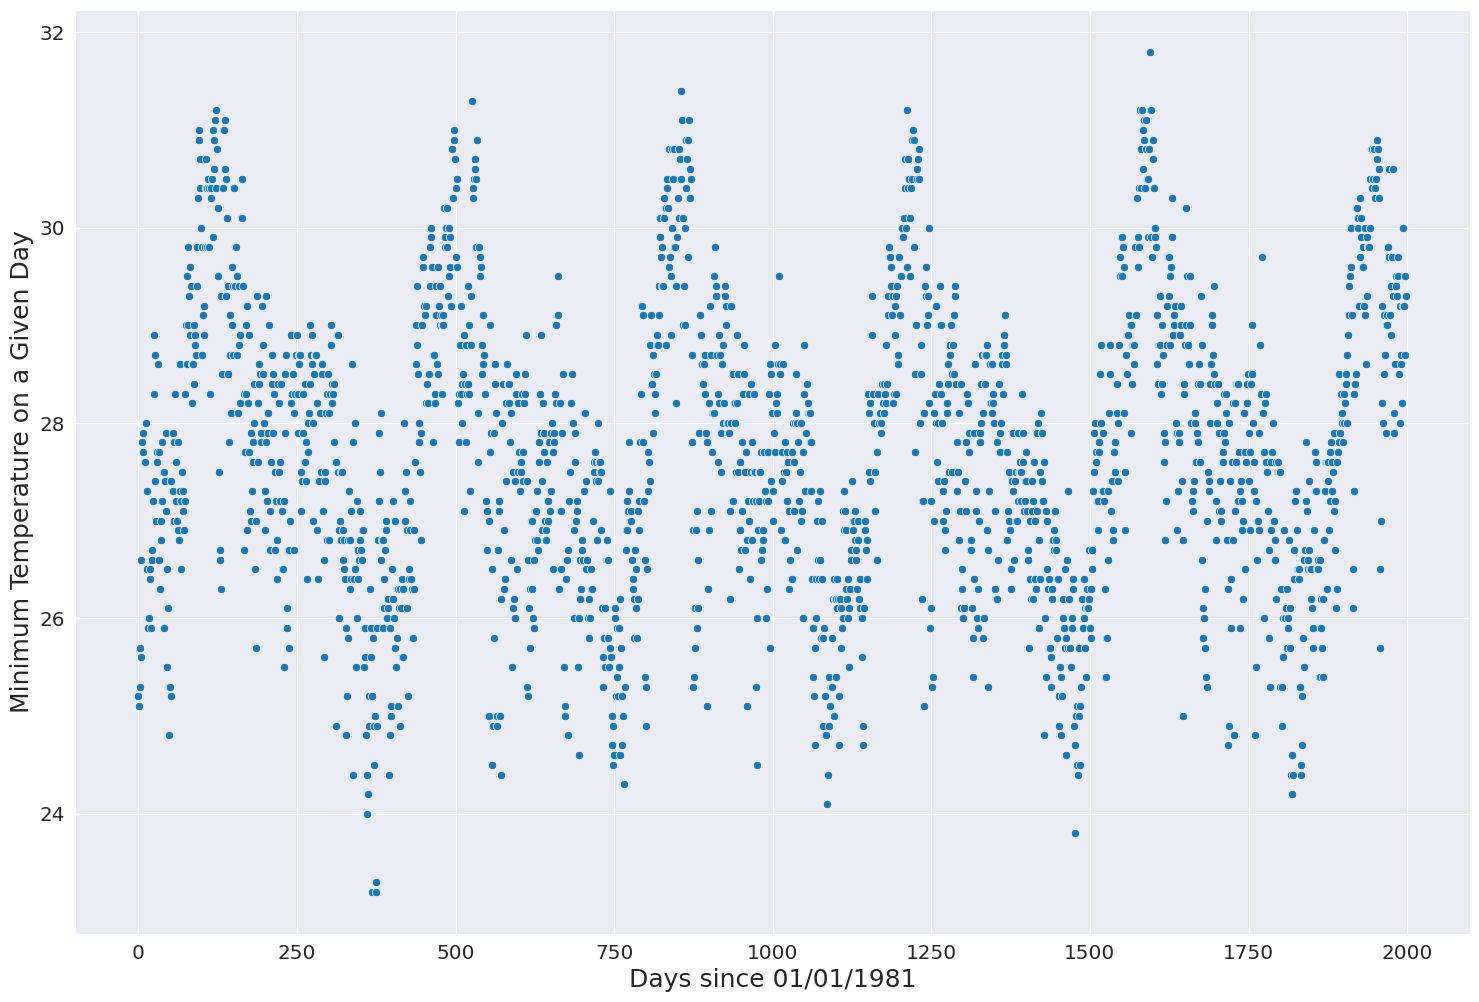

In [177]:
plt.figure(figsize=(18, 12))
sns.scatterplot(data=df, x='index', y='Temp')
plt.xlabel('Days since 01/01/1981', fontsize=18)
plt.ylabel('Minimum Temperature on a Given Day', fontsize=18)
#plt.savefig('filename.png', dpi=300)
plt.show()


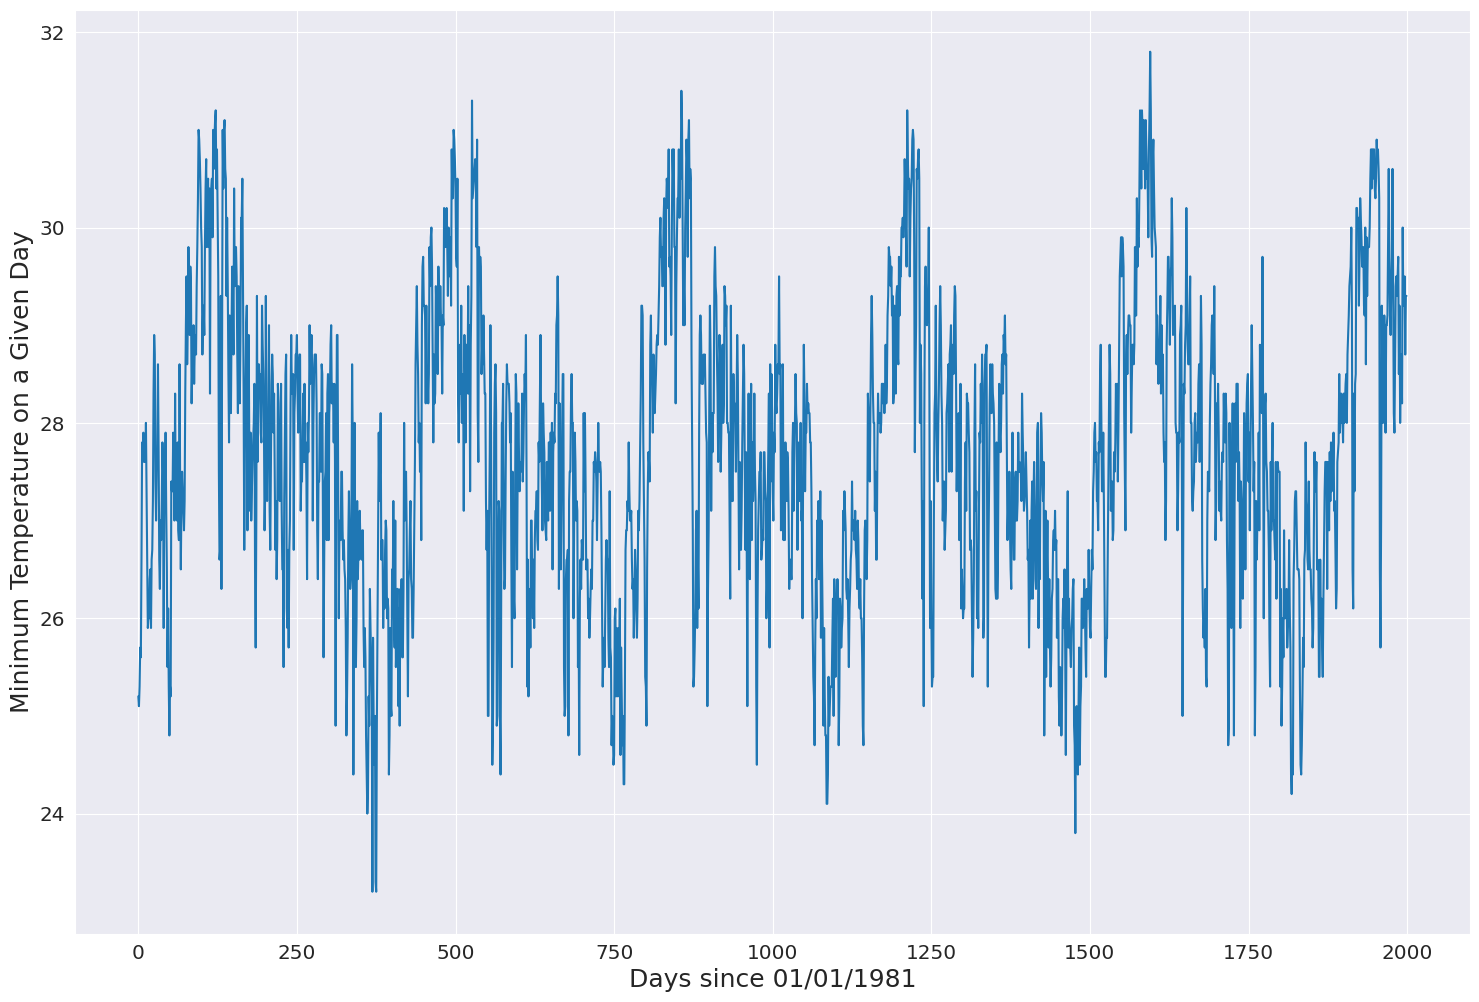

In [178]:
plt.figure(figsize=(18, 12))
plt.plot(df["Temp"])
plt.xlabel('Days since 01/01/1981', fontsize=18)
plt.ylabel('Minimum Temperature on a Given Day', fontsize=18)
#plt.savefig('filename.png', dpi=300)
plt.show()


## Processing Data
#### The graph shows obvious seasonality, so a good hypothesis would be that the mean temperature has a huge dependance on the month.
#### Additionally, a good practice is to keep the mean of the data at 0.
####Ultimately our goal is to make the dataset as close as possible to being stationary, so we can easily model it.

In [179]:
df['TempMod'] = df['Temp']

In [180]:
df['Month'] = pd.DatetimeIndex(df['Date']).month

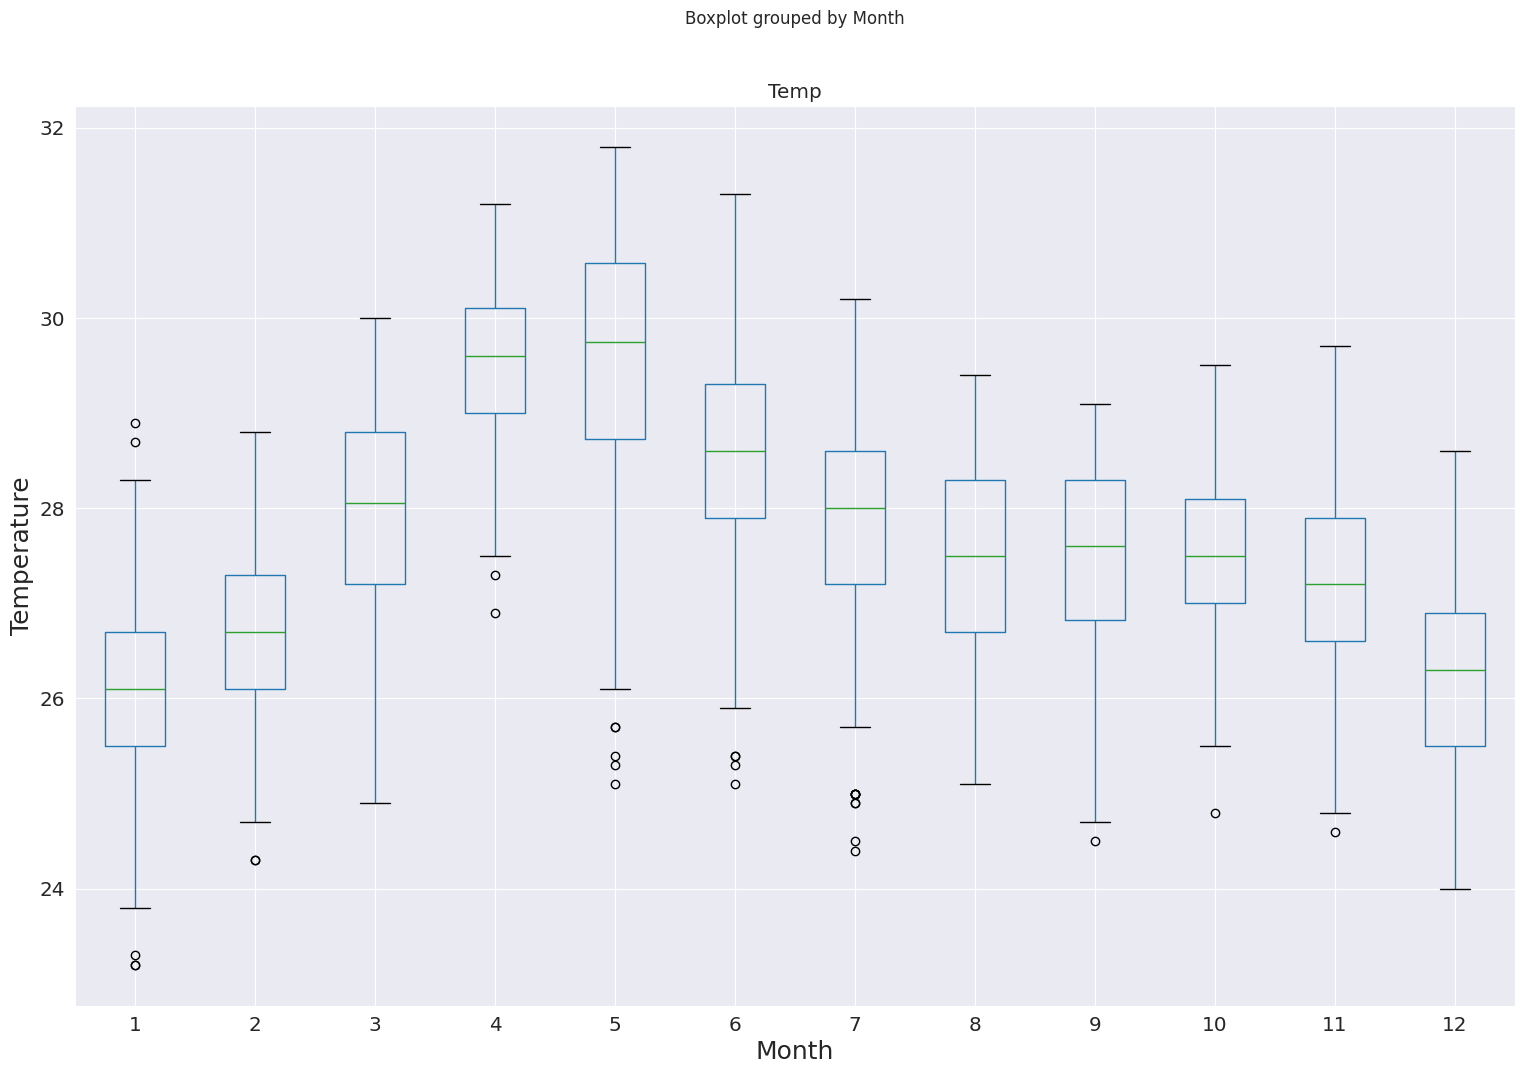

In [181]:
fig, ax = plt.subplots(figsize=(18,12))
plt.suptitle('')
df.boxplot(column=['Temp'], by='Month', ax=ax)
plt.xlabel('Month', fontsize=18)
plt.ylabel('Temperature', fontsize=18)
plt.show()

Here it's obvious that there is a very good connection between month and temperature, and that the connection explains the seasonality of this data. Thus we will proceed to remove this seasonality.

In [182]:
# Need to Do all of this to remove the seasonality of data (and make it a linear Regression)

# Get The Mean for each Month for Temp
month_grp = df.groupby(by='Month').mean(numeric_only = True)['Temp']

# For Every Month in the list of unique Months in the Dataframe
for month in df['Month'].unique():
  # Look for df["Month"] == current unique month, Change TempMod Value to be (currentTemp of the Day) - (Monthly Mean)
  df.loc[df['Month'] == month, 'TempMod'] -= month_grp[month]
  
# Get The Mean of the Normalized Month Groups
mean = df['TempMod'].mean()
print("Current Mean:", mean)

# Subtract the Normalized Temperature Mean by the Total Mean of all the other Normalized
df['TempMod'] = df['TempMod'] - mean

Current Mean: 6.394884621840901e-17


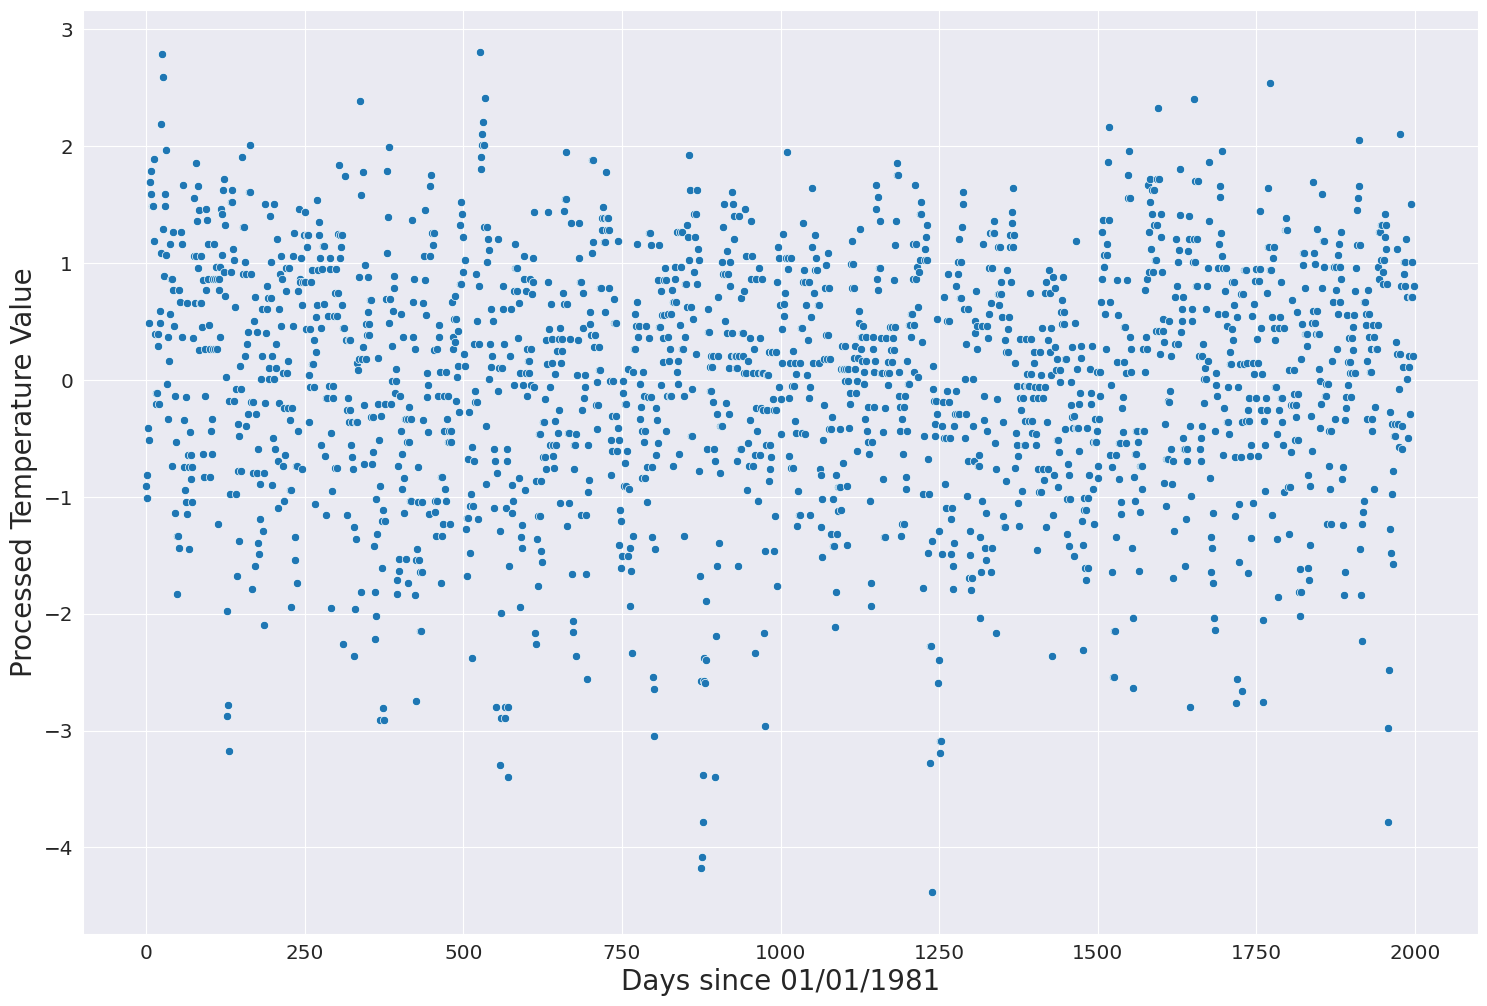

In [183]:
# This should now display a pretty non seasonal data, ultimately converting Non Linear to Linear
plt.figure(figsize=(18, 12))
sns.scatterplot(data=df, x='index', y='TempMod')
plt.xlabel('Days since 01/01/1981', fontsize=20)
plt.ylabel('Processed Temperature Value', fontsize=20)
plt.show()

In [184]:
df['TempMod'].mean()

4.9737991503207014e-17

An important step is to understand the order of the model we want, be it an AR, MA, ARMA or ARIMA model. We can best infer the order from the graphs of Autocorrelation and Partial Autocorrelation of the data.

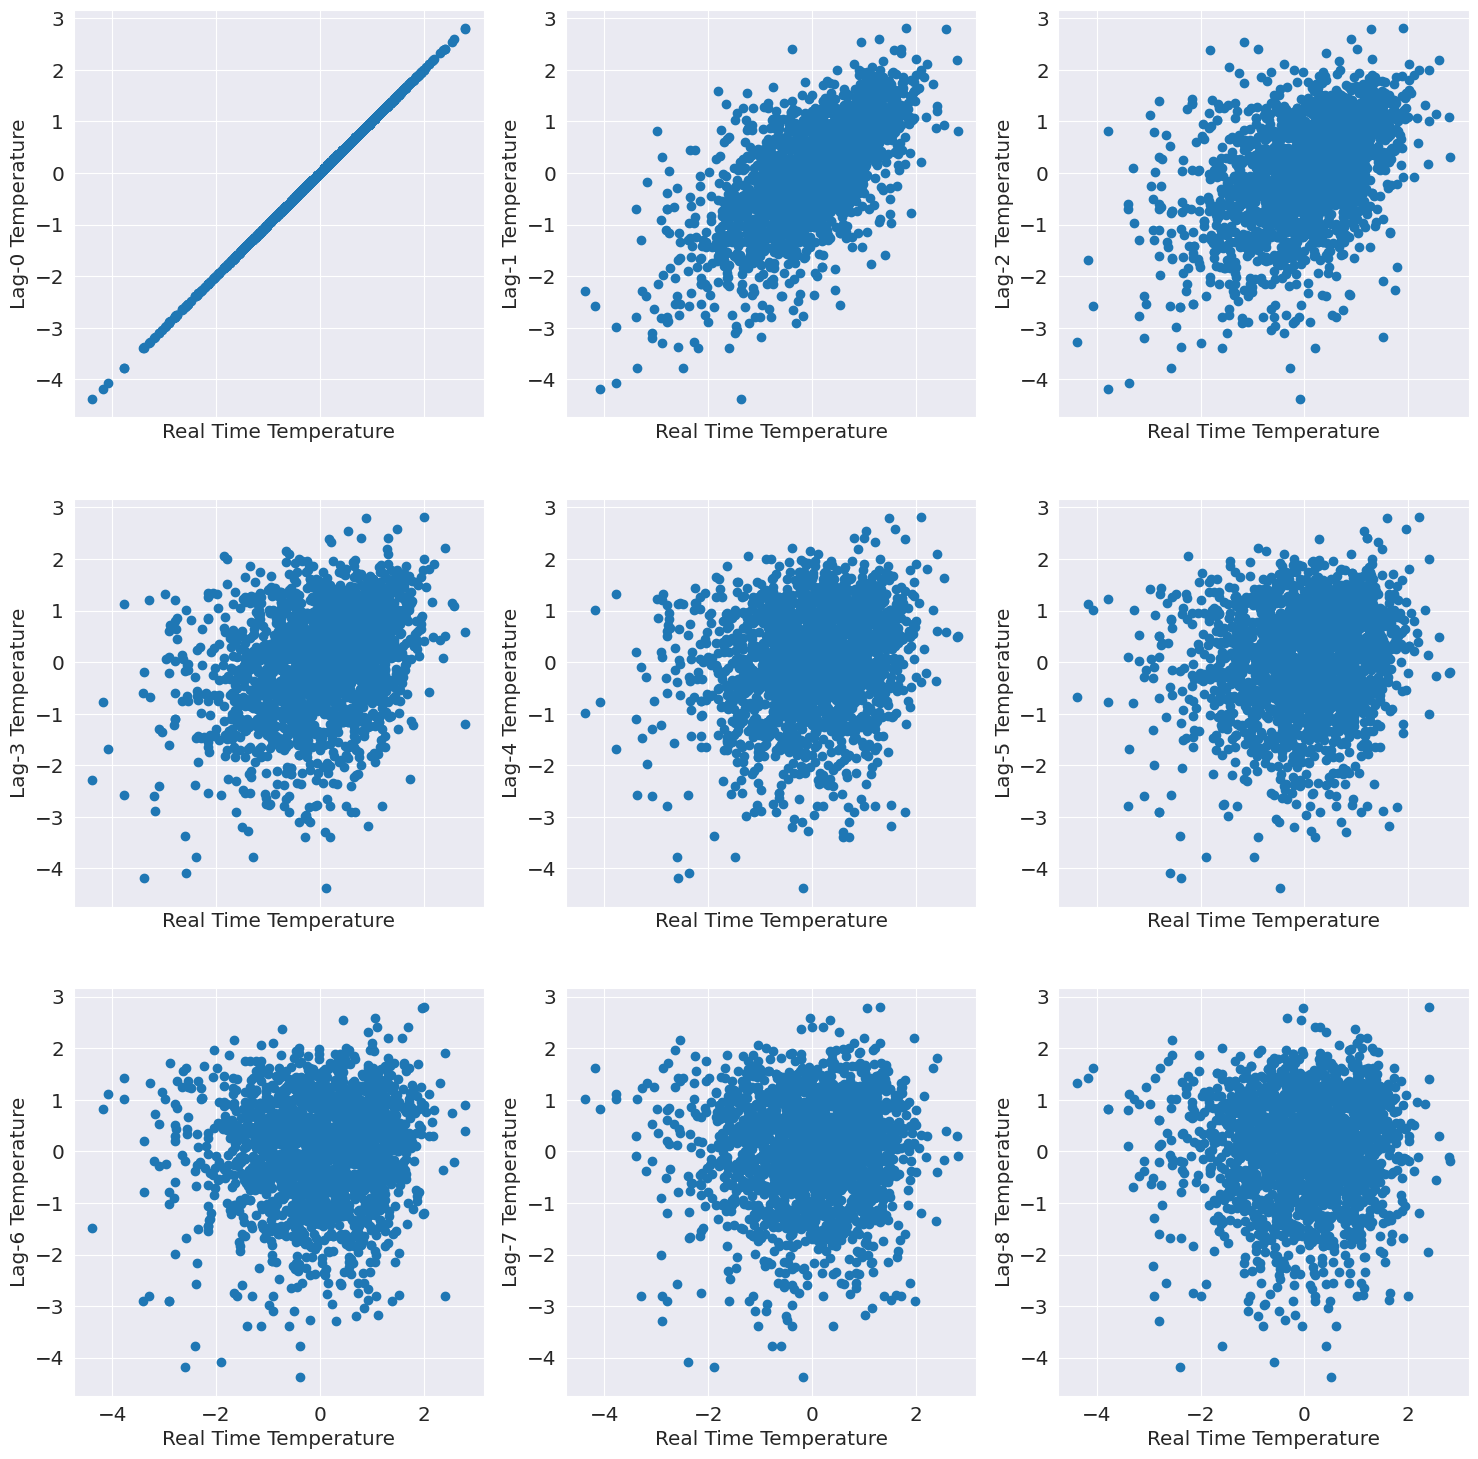

In [185]:
n = 9
current = df['TempMod'][n:]
fig, axis = plt.subplots(3, n//3, sharex=True, figsize=(18, 18))

for i in range(n):
  if i != 0:
    lag = df['TempMod'][(n-i):-i]
  else:
    lag = current
  axis[(i)//3, (i)%3].set(xlabel='Real Time Temperature', ylabel=f'Lag-{i} Temperature')
  axis[(i)//3, (i)%3].scatter(current, lag)

plt.show()

In [186]:
auto_corr = [df['TempMod'].autocorr(lag=k) for k in range(1, 50)]

In [187]:
# from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

In [188]:
# fig, axes = plt.subplots(2, 1, figsize=(18, 20), sharey=True)

# plot_acf(ax=axes[0], x=df['TempMod'], lags=50)

# plot_pacf(ax=axes[1], x=df['TempMod'], lags=50)

# plt.show()

In [189]:
X = df['TempMod']
X.head()
print(len(X))

2000


# AR(p)
$
X_t = \sum_{i=1}^p -\psi_i X_{t-i}+\eta_t
$

$\eta_i = N(0, \sigma_\eta^2)$

In [190]:
class AR:
  def __init__(self, p):
    self.p = p
    # self.model = LinearRegression()
    self.model = RandomForestRegressor()
    self.sigma = None

  def generate_train_x(self, X):
    n = len(X)
    ans = X[:n-self.p]
    ans = np.reshape(ans, (-1, 1))
    for k in range(1, self.p):
      temp = X[k:n-self.p+k]
      temp = np.reshape(temp, (-1, 1))
      ans = np.hstack((ans, temp))
    return ans
  
  def generate_train_y(self, X):
    return X[self.p:]

  def fit(self, X):
    self.sigma = np.std(X)
    train_x = self.generate_train_x(X)
    train_y = self.generate_train_y(X)
    self.model.fit(train_x, train_y)

  def predict(self, X, num_predictions, mc_depth):
    X = np.array(X)
    ans = np.array([])

    for j in range(mc_depth):
      ans_temp = []
      a = X[-self.p:]

      for i in range(num_predictions):
        next = self.model.predict(np.reshape(a, (1, -1))) + np.random.normal(loc=0, scale=self.sigma)

        ans_temp.append(next)
        
        a = np.roll(a, -1)
        a[-1] = next
      
      if j==0:
        ans = np.array(ans_temp)
      
      else:
        ans += np.array(ans_temp)
    
    ans /= mc_depth

    return ans
  
  def score(self, X):
    train_x = self.generate_train_x(X)
    train_y = self.generate_train_y(X)
    return self.model.score(train_x, train_y)

In [191]:
p=11 # Tried 3 and has .91 Correlation Score
n_train = 2000
n=3600
model = AR(p)

In [192]:
X = np.array(X)
print(len(X))
model.fit(X)

2000


In [193]:
prediction = model.predict(X[:p], n, 1)
prediction = np.reshape(prediction, (-1,))
prediction = np.hstack((X[:p], prediction))
prediction.shape

/tmp/ipykernel_12208/1386534971.py:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  a[-1] = next
/tmp/ipykernel_12208/1386534971.py:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  a[-1] = next
/tmp/ipykernel_12208/1386534971.py:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  a[-1] = next
/tmp/ipykernel_12208/1386534971.py:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a singl

/tmp/ipykernel_12208/1386534971.py:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  a[-1] = next
/tmp/ipykernel_12208/1386534971.py:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  a[-1] = next
/tmp/ipykernel_12208/1386534971.py:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  a[-1] = next
/tmp/ipykernel_12208/1386534971.py:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a singl

(3611,)

In [194]:
range_check = 200

real = df[:range_check]['TempMod']
len(real)

200

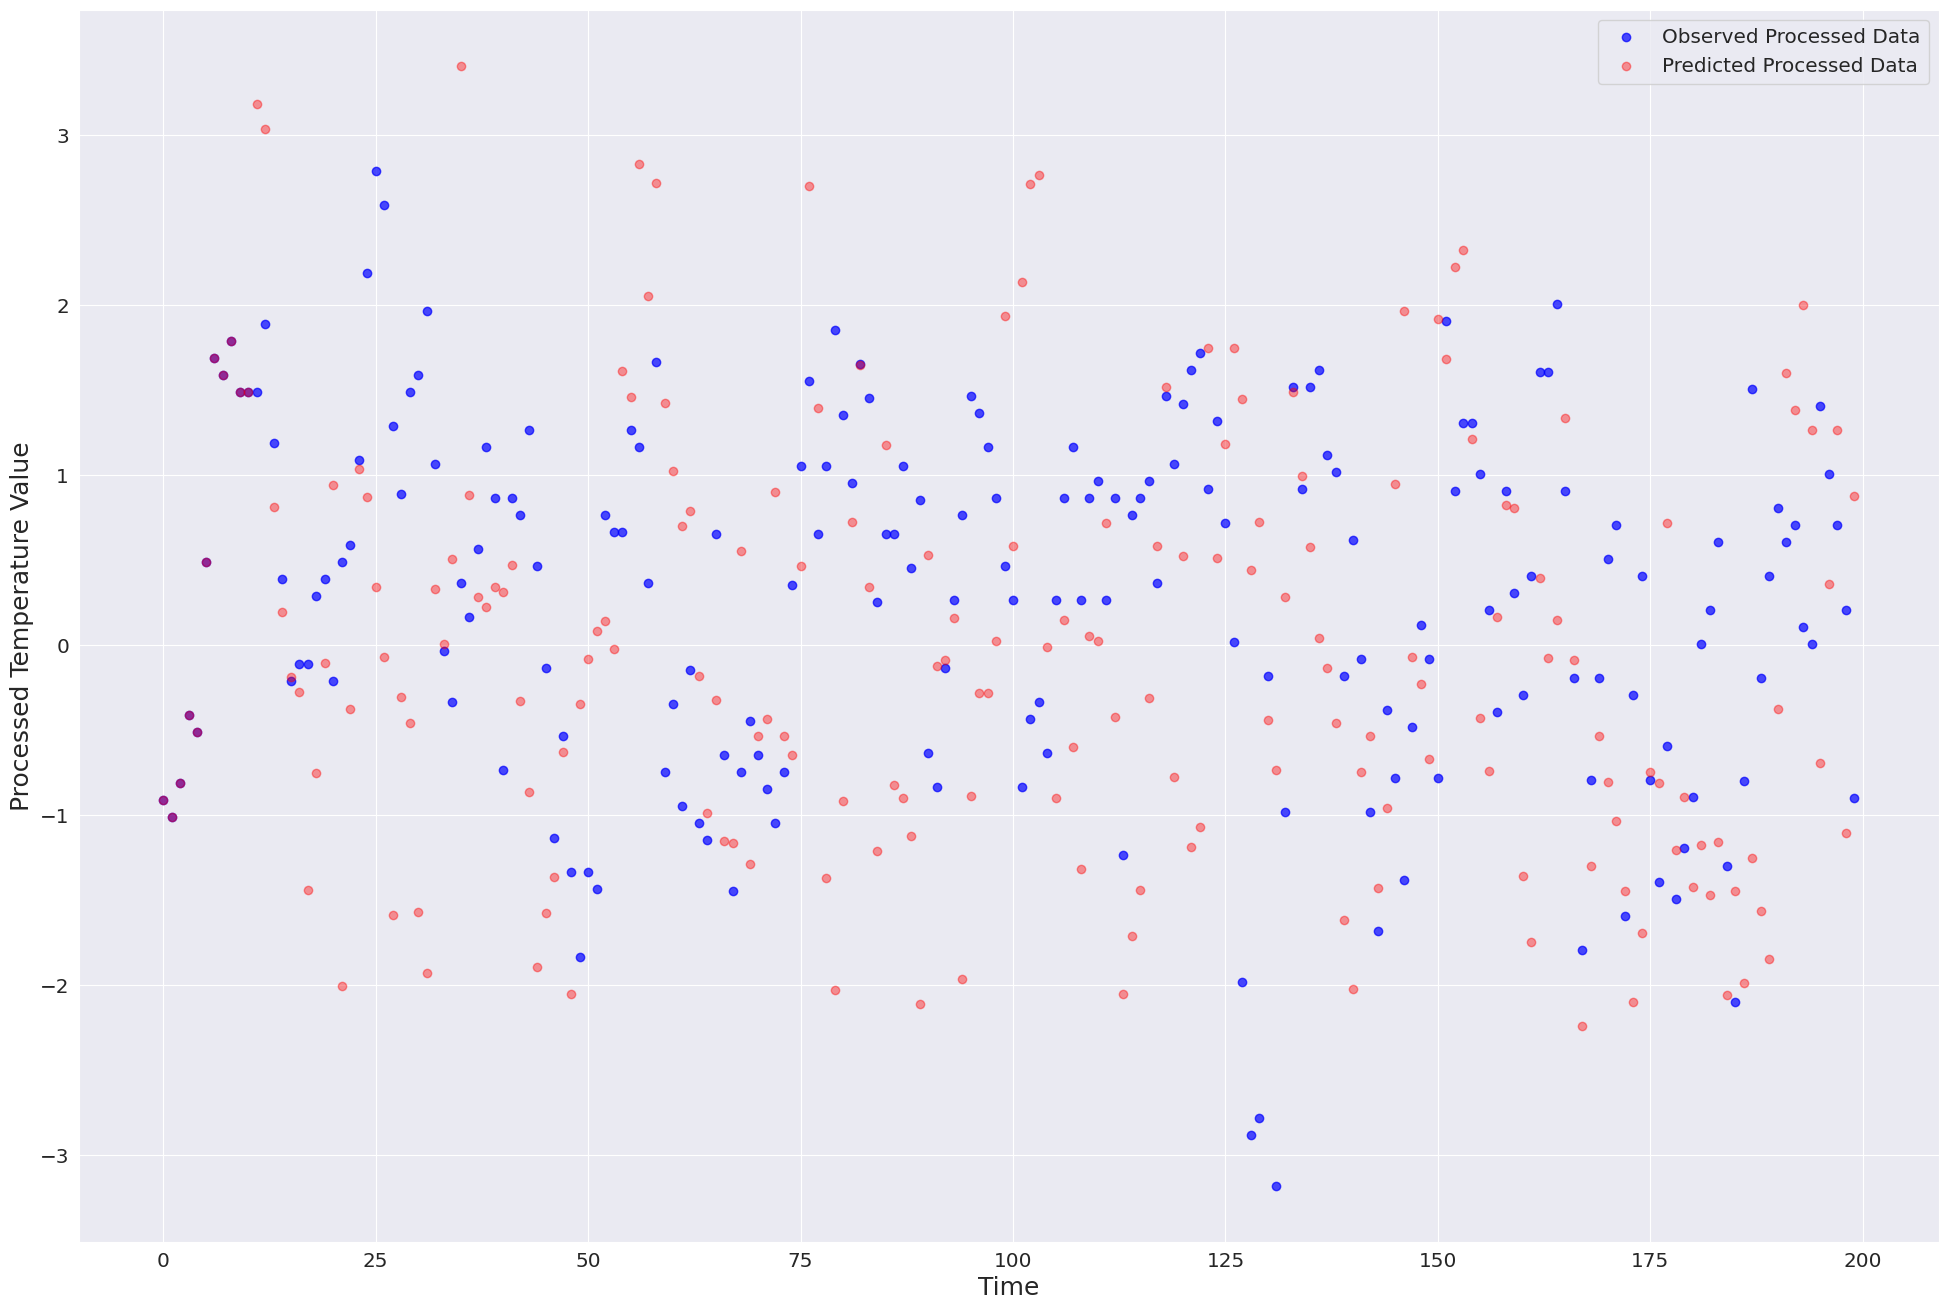

In [195]:
# Performing a sanity check on the data
plt.figure(figsize=(24, 16))
plt.scatter(x=np.arange(range_check), y=real, color='blue', alpha=0.7)
plt.scatter(x=np.arange(range_check), y=prediction[:range_check], color='red', alpha=0.4)
plt.legend(loc='upper right', labels=['Observed Processed Data', 'Predicted Processed Data'])
plt.xlabel('Time', fontsize=18)
plt.ylabel('Processed Temperature Value', fontsize=18)
plt.show()

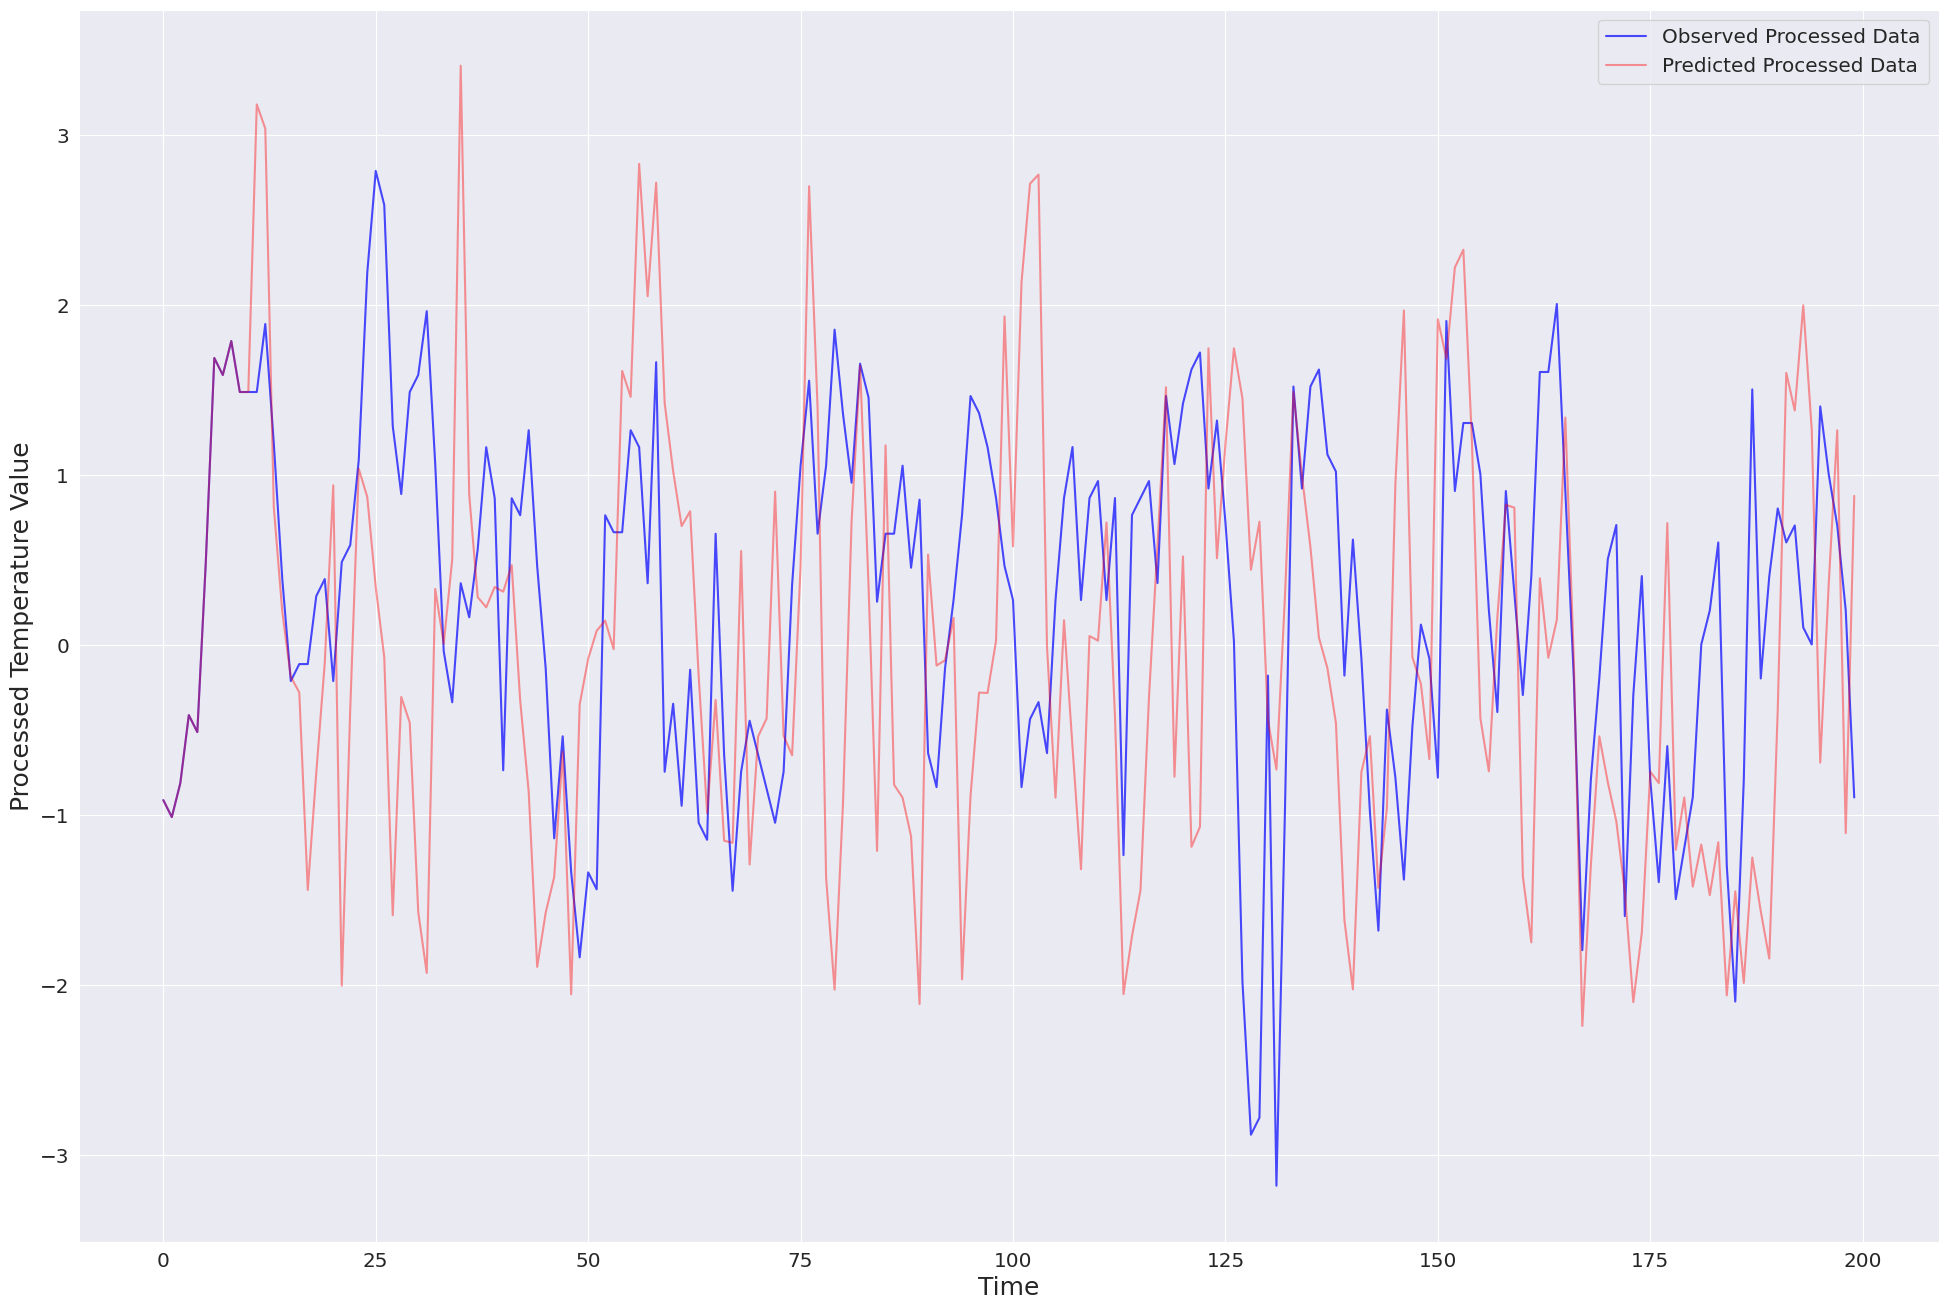

In [196]:
plt.figure(figsize=(24, 16))
plt.plot(real, color='blue', alpha=0.7)
plt.plot(prediction[:range_check], color='red', alpha=0.4)
plt.legend(loc='upper right', labels=['Observed Processed Data', 'Predicted Processed Data'])
plt.xlabel('Time', fontsize=18)
plt.ylabel('Processed Temperature Value', fontsize=18)
plt.show()

In [197]:
model.score(X)

0.9200457666859058

In [198]:
data["Date"]

0       2001-01-01
1       2001-01-02
2       2001-01-03
3       2001-01-04
4       2001-01-05
           ...    
8509    2024-04-19
8510    2024-04-20
8511    2024-04-21
8512    2024-04-22
8513    2024-04-23
Name: Date, Length: 8514, dtype: object

In [199]:
pred_dates = data['Date'][:len(prediction)]
prediction

array([-0.91075269, -1.01075269, -0.81075269, ...,  2.51549226,
        2.13228396,  0.85222331])

In [200]:
preds = pd.concat(objs=[pred_dates, pd.Series(prediction)], axis=1)

In [201]:
preds.columns = ['Date', 'PredTemp']
preds['Month'] = pd.DatetimeIndex(preds['Date']).month
preds

Date  PredTemp  Month
0     2001-01-01 -0.910753      1
1     2001-01-02 -1.010753      1
2     2001-01-03 -0.810753      1
3     2001-01-04 -0.410753      1
4     2001-01-05 -0.510753      1
...          ...       ...    ...
3606  2010-11-16  0.675241     11
3607  2010-11-17  0.528342     11
3608  2010-11-18  2.515492     11
3609  2010-11-19  2.132284     11
3610  2010-11-20  0.852223     11

[3611 rows x 3 columns]

In [202]:
preds['Zero'] = 0
preds

Date  PredTemp  Month  Zero
0     2001-01-01 -0.910753      1     0
1     2001-01-02 -1.010753      1     0
2     2001-01-03 -0.810753      1     0
3     2001-01-04 -0.410753      1     0
4     2001-01-05 -0.510753      1     0
...          ...       ...    ...   ...
3606  2010-11-16  0.675241     11     0
3607  2010-11-17  0.528342     11     0
3608  2010-11-18  2.515492     11     0
3609  2010-11-19  2.132284     11     0
3610  2010-11-20  0.852223     11     0

[3611 rows x 4 columns]

In [203]:
preds = preds.reset_index()

In [204]:
month_grp = (df.groupby(by='Month').mean(numeric_only=True)['Temp'])
for month in df['Month'].unique():
  preds.loc[preds['Month']==month, 'PredTemp'] += month_grp[month]
  preds.loc[preds['Month']==month, 'Zero'] += month_grp[month]

/tmp/ipykernel_12208/3465112896.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[26.11075269 26.11075269 26.11075269 26.11075269 26.11075269 26.11075269
 26.11075269 26.11075269 26.11075269 26.11075269 26.11075269 26.11075269
 26.11075269 26.11075269 26.11075269 26.11075269 26.11075269 26.11075269
 26.11075269 26.11075269 26.11075269 26.11075269 26.11075269 26.11075269
 26.11075269 26.11075269 26.11075269 26.11075269 26.11075269 26.11075269
 26.11075269 26.11075269 26.11075269 26.11075269 26.11075269 26.11075269
 26.11075269 26.11075269 26.11075269 26.11075269 26.11075269 26.11075269
 26.11075269 26.11075269 26.11075269 26.11075269 26.11075269 26.11075269
 26.11075269 26.11075269 26.11075269 26.11075269 26.11075269 26.11075269
 26.11075269 26.11075269 26.11075269 26.11075269 26.11075269 26.11075269
 26.11075269 26.11075269 26.11075269 26.11075269 26.11075269 26.11075269
 26.11075269 26.11075269 26.11

In [205]:
for month in df['Month'].unique():
  preds.loc[preds['Month']==month, 'Zero'] += month_grp[month]

In [214]:
data

Date  Temp
0     2001-01-01  25.2
1     2001-01-02  25.1
2     2001-01-03  25.3
3     2001-01-04  25.7
4     2001-01-05  25.6
...          ...   ...
8509  2024-04-19  30.9
8510  2024-04-20  31.1
8511  2024-04-21  31.2
8512  2024-04-22  31.6
8513  2024-04-23  31.5

[8514 rows x 2 columns]

In [206]:
preds['PredTemp'] += mean
preds.tail()

index        Date   PredTemp  Month       Zero
3606   3606  2010-11-16  27.834574     11  54.318667
3607   3607  2010-11-17  27.687675     11  54.318667
3608   3608  2010-11-18  29.674826     11  54.318667
3609   3609  2010-11-19  29.291617     11  54.318667
3610   3610  2010-11-20  28.011557     11  54.318667

In [207]:
preds['Zero'] += mean
preds.tail()

index        Date   PredTemp  Month       Zero
3606   3606  2010-11-16  27.834574     11  54.318667
3607   3607  2010-11-17  27.687675     11  54.318667
3608   3608  2010-11-18  29.674826     11  54.318667
3609   3609  2010-11-19  29.291617     11  54.318667
3610   3610  2010-11-20  28.011557     11  54.318667

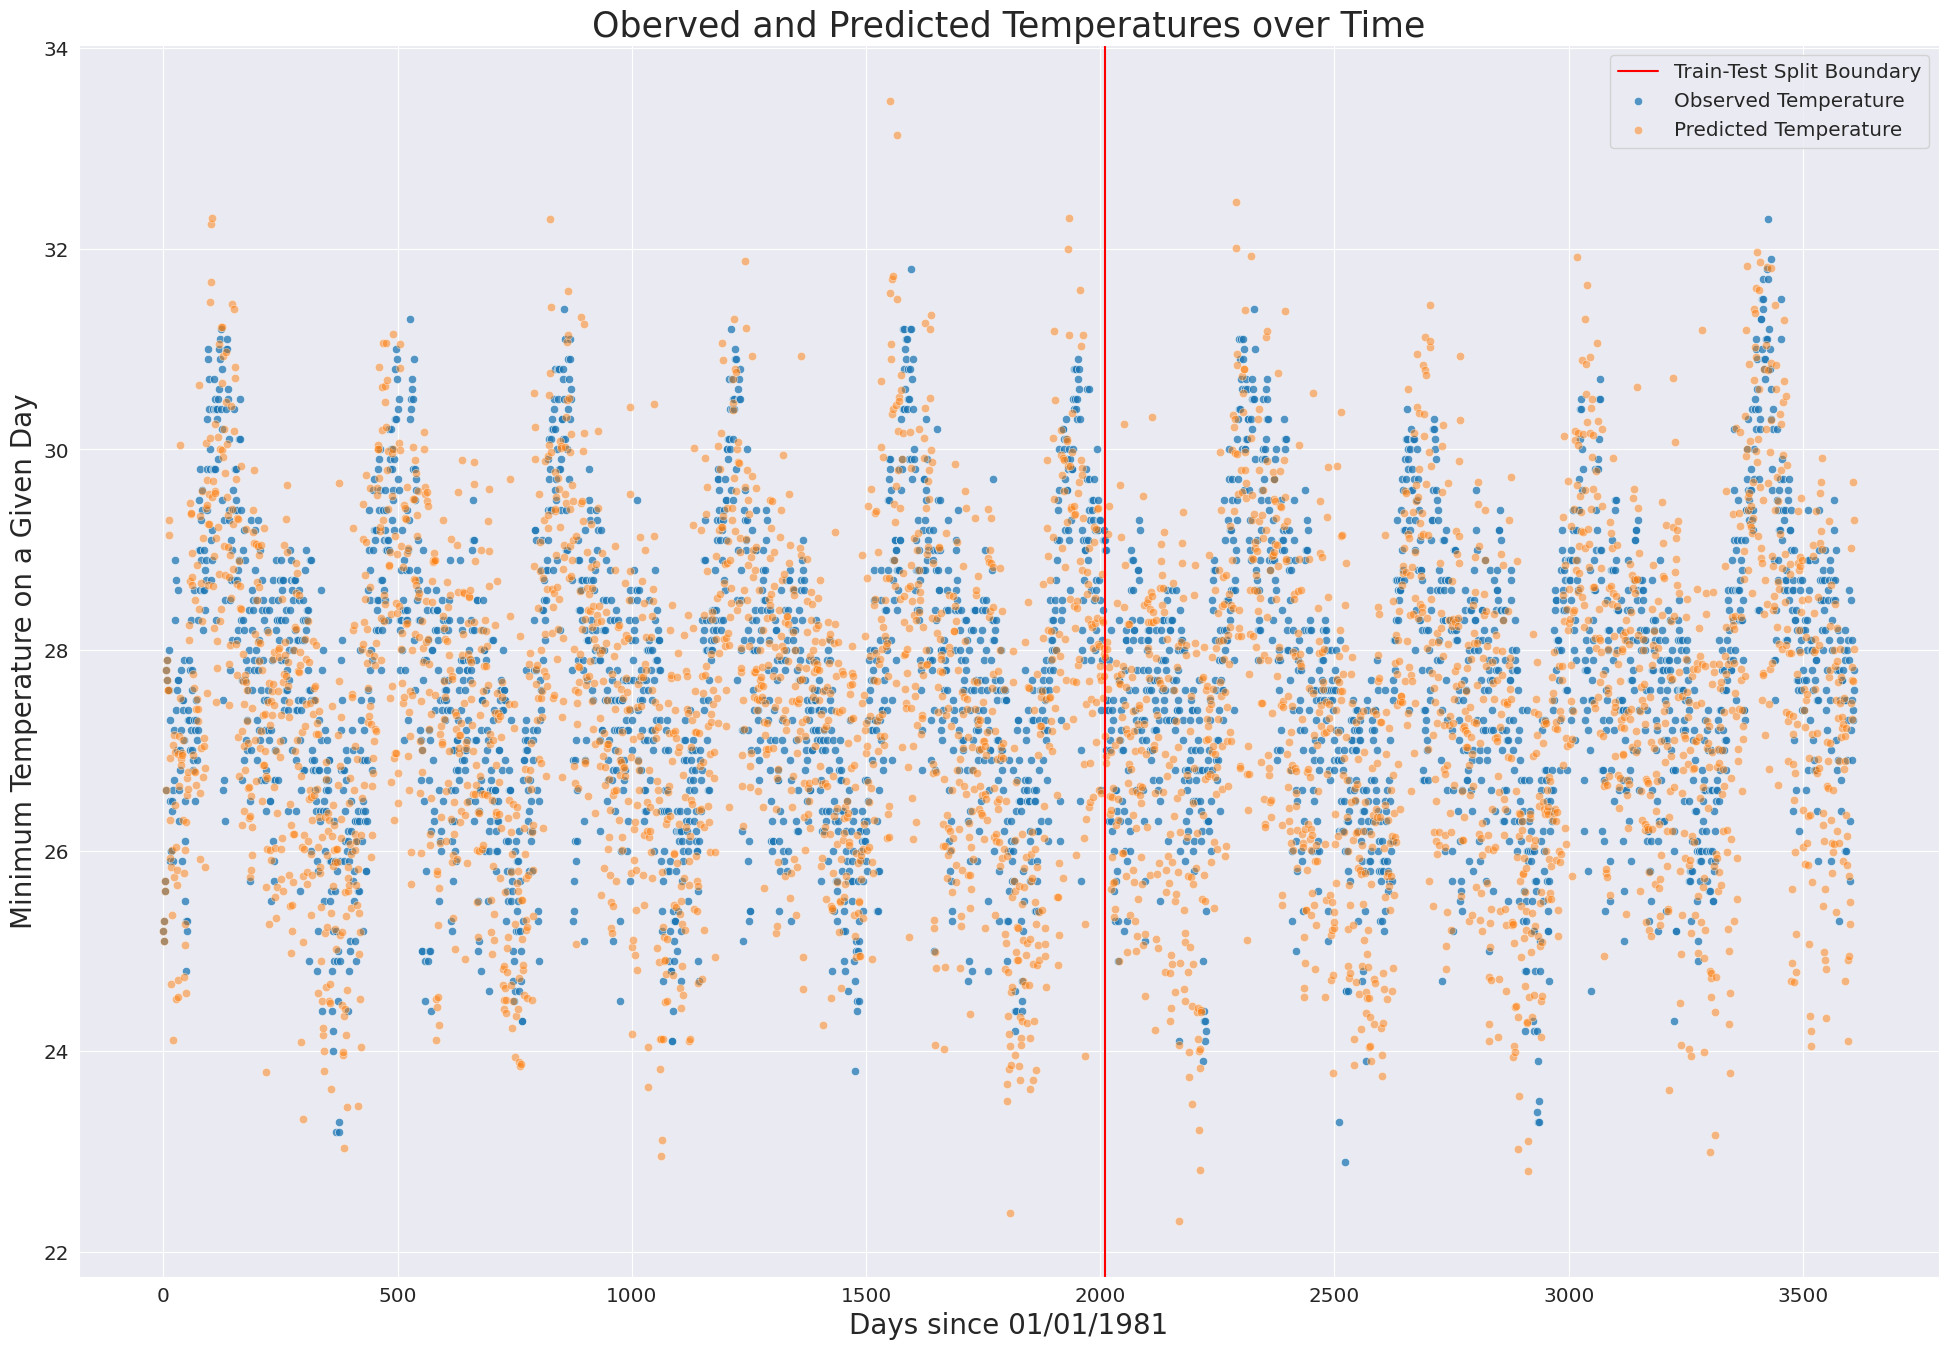

In [208]:
plt.figure(figsize=(24, 16))
plt.title('Oberved and Predicted Temperatures over Time', fontsize=25)
plt.axvline(x=n_train+p, c='red')
sns.scatterplot(x=preds['index'], y=data['Temp'], alpha=0.75)
sns.scatterplot(x=preds['index'], y=preds['PredTemp'], alpha=0.5)

plt.legend(loc='upper right', labels=['Train-Test Split Boundary','Observed Temperature', 'Predicted Temperature'])
plt.xlabel('Days since 01/01/1981', fontsize=20)
plt.ylabel('Minimum Temperature on a Given Day', fontsize=20)
plt.show()

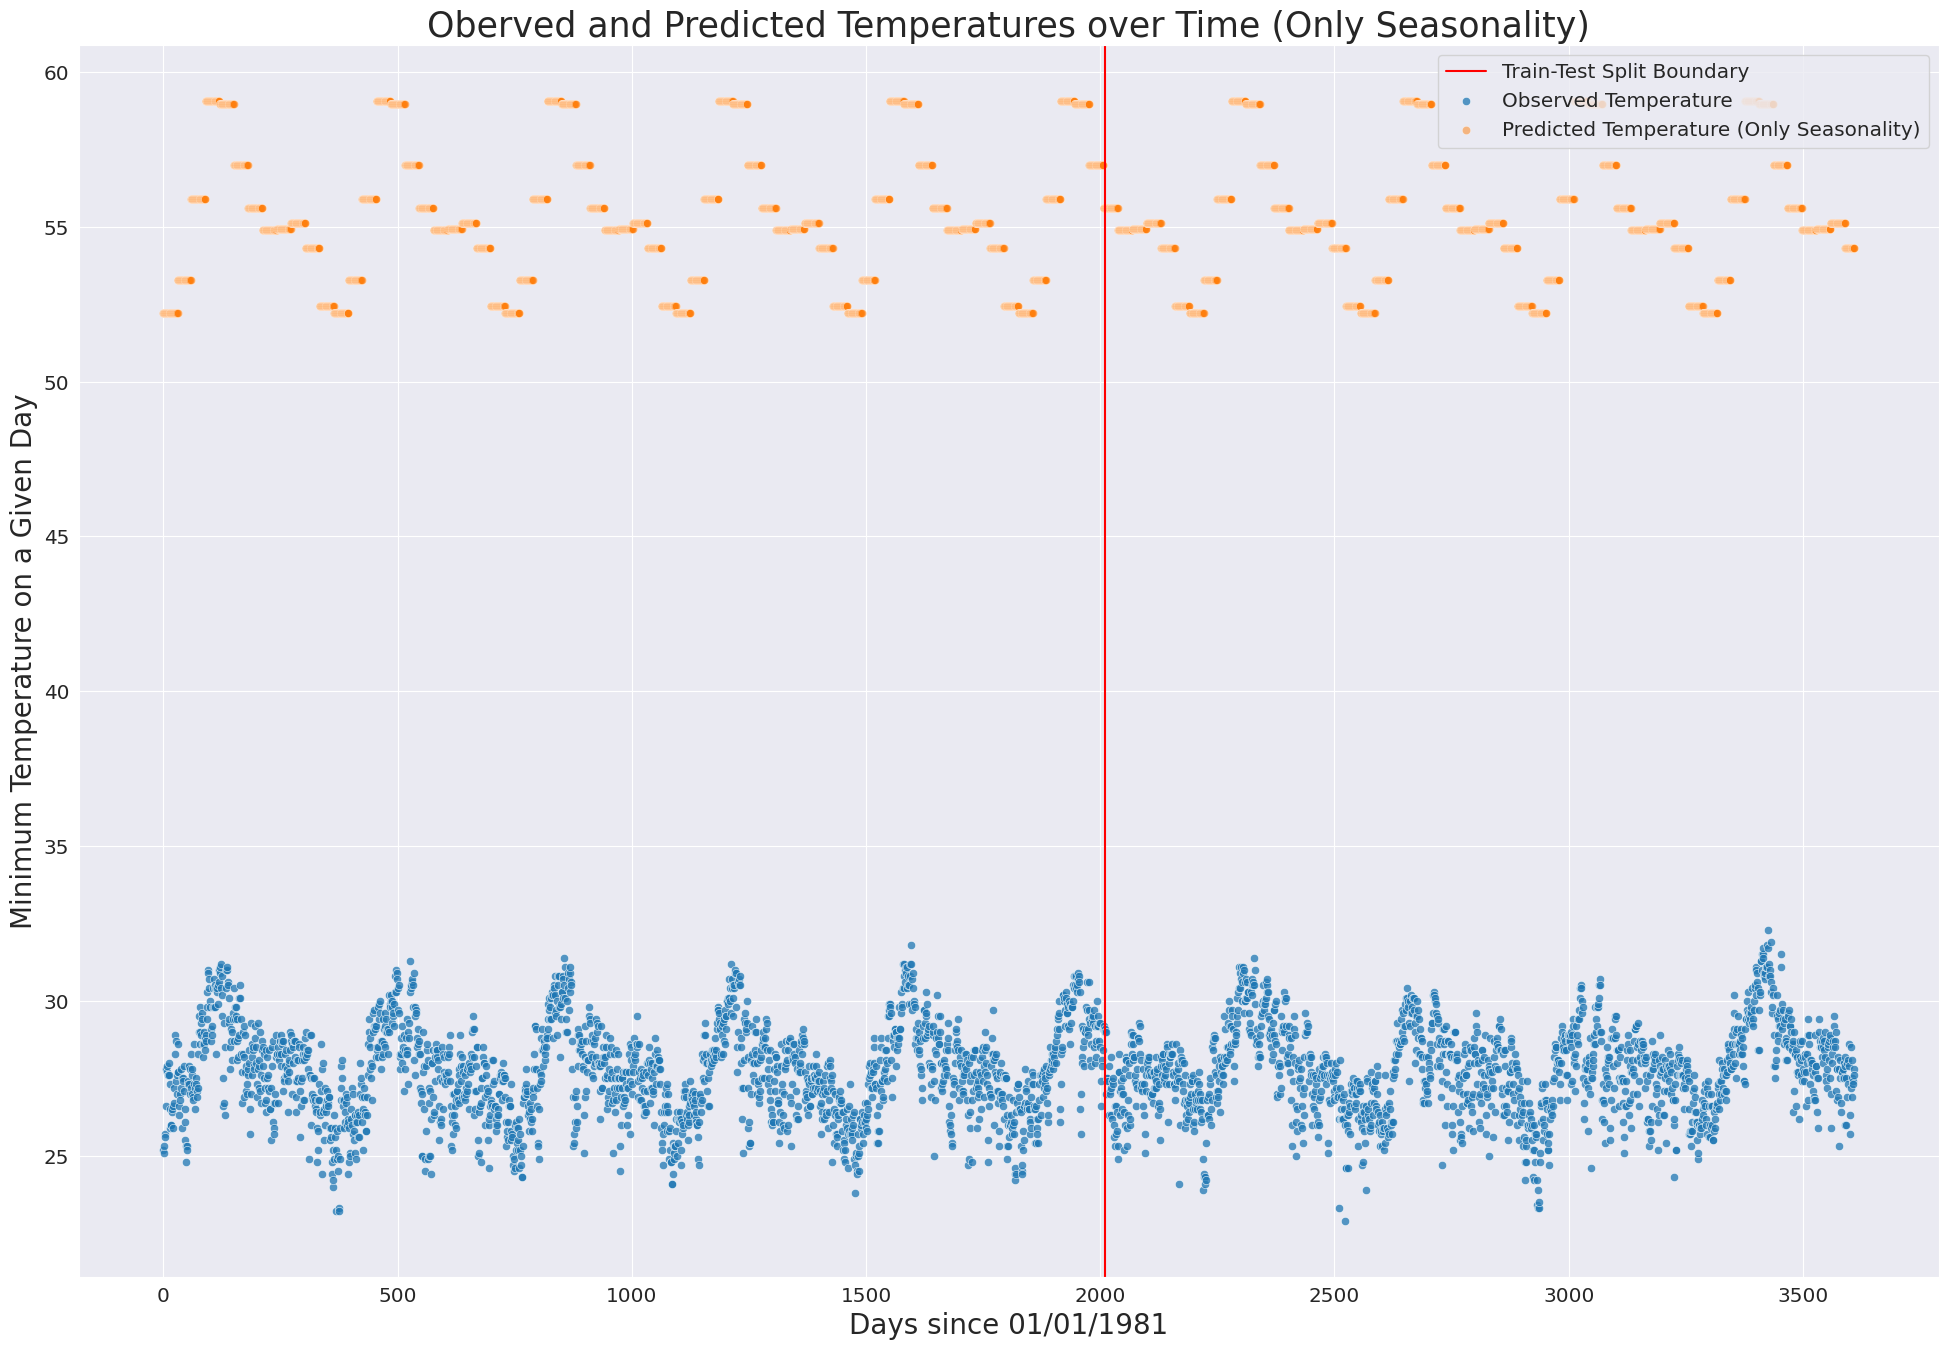

In [209]:
plt.figure(figsize=(24, 16))
plt.title('Oberved and Predicted Temperatures over Time (Only Seasonality)', fontsize=25)
plt.axvline(x=n_train+p, c='red')
sns.scatterplot(x=preds['index'], y=data['Temp'], alpha=0.75)
sns.scatterplot(x=preds['index'], y=preds['Zero'], alpha=0.5)
plt.legend(loc='upper right', labels=['Train-Test Split Boundary','Observed Temperature', 'Predicted Temperature (Only Seasonality)'])
plt.xlabel('Days since 01/01/1981', fontsize=20)
plt.ylabel('Minimum Temperature on a Given Day', fontsize=20)
plt.show()

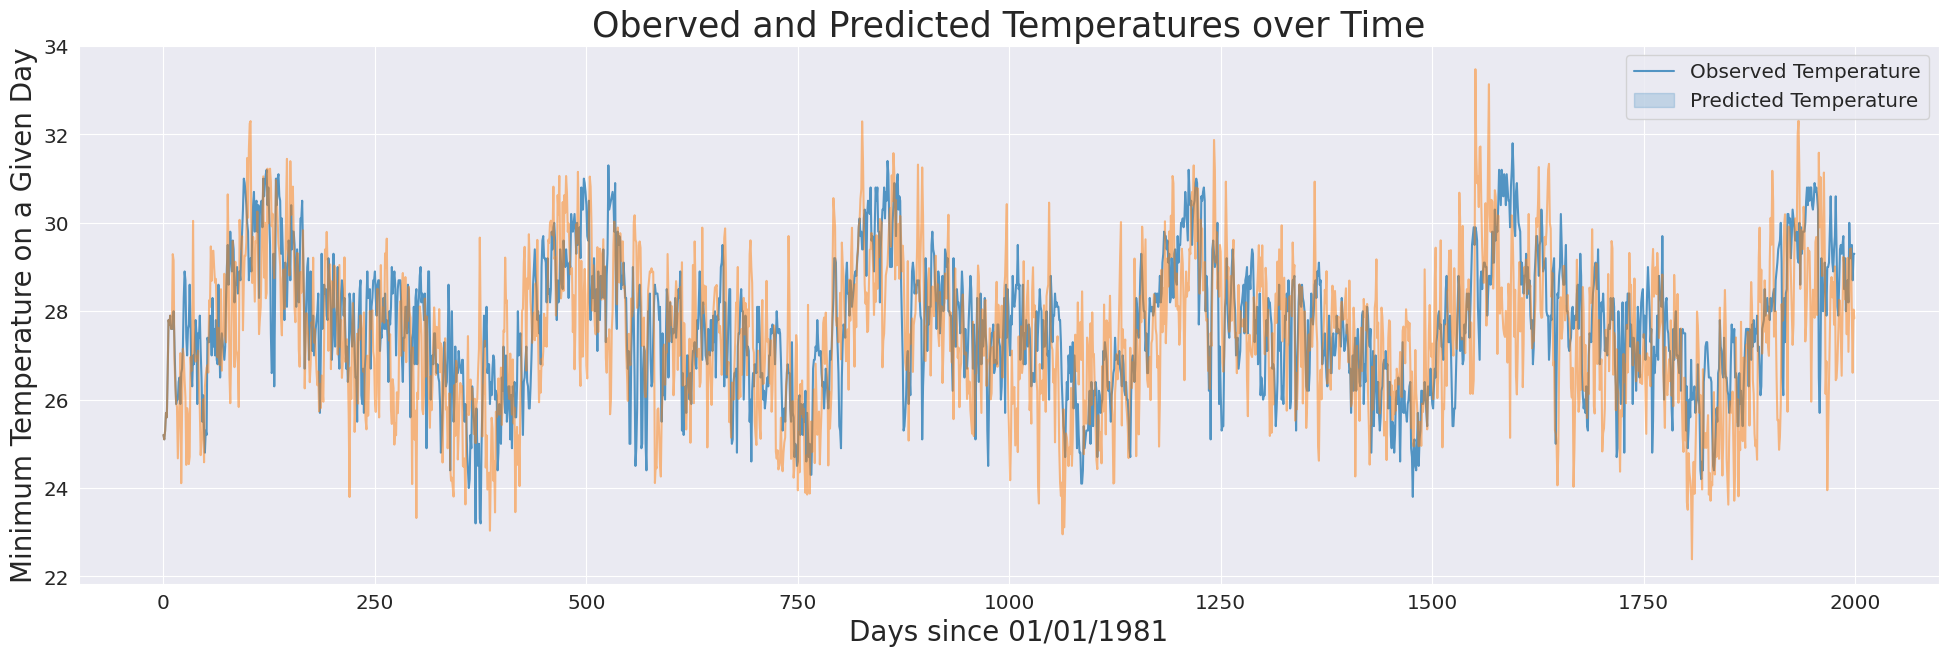

In [210]:
range_check = 2000
plt.figure(figsize=(24, 7))
plt.title('Oberved and Predicted Temperatures over Time', fontsize=25)
# plt.axvline(x=n_train+p, c='red')
sns.lineplot(x=preds['index'][:range_check], y=data['Temp'], alpha=0.75)
sns.lineplot(x=preds['index'][:range_check], y=preds['PredTemp'], alpha=0.5)

# plt.legend(loc='upper right', labels=['Train-Test Split Boundary','Observed Temperature', 'Predicted Temperature'])
plt.legend(loc='upper right', labels=['Observed Temperature', 'Predicted Temperature'])
plt.xlabel('Days since 01/01/1981', fontsize=20)
plt.ylabel('Minimum Temperature on a Given Day', fontsize=20)
plt.show()

# Other Graphs for Testing

In [211]:
# data = np.random.normal(0, 2, (200))
# plt.figure(figsize=(18, 10))
# sns.scatterplot(x=np.arange(200), y=data)
# plt.show()

In [212]:
# x = np.arange(400)/2
# y = np.sin(x * 6.28 / 30)
# plt.figure(figsize=(18, 10))
# sns.scatterplot(x=x, y=y)
# plt.show()

In [213]:
# x = np.arange(400)/2
# y = np.sin(x * 6.28 / 30)*np.exp(x/100) + x/20
# plt.figure(figsize=(18, 10))
# sns.scatterplot(x=x, y=y)
# plt.show()